In [11]:
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")

## Get Data
Monthly EIA Generation data is available for buik download from the EIA website. The data is provided as a zip file which needs a little processing

In [ ]:
url = "https://www.eia.gov/opendata/bulk/ELEC.zip"
response = requests.get(url)
# save response content to disk
with open("ELEC.zip", "wb") as f:
    f.write(response.content)

In [2]:
def process_chunk(
    c: pd.DataFrame,
):
    metadata = c.set_index("series_id").copy()
    data = metadata["data"].explode()
    dates = data.apply(lambda x: x[0] if isinstance(x, list) else None)
    values = data.apply(lambda x: x[1] if isinstance(x, list) else None)
    data = pd.concat({"date": dates, "value": values}, axis=1).dropna()
    return metadata.drop("data", axis=1), data

# read the json in chunks
reader = pd.read_json("ELEC.zip", lines=True, orient="columns", chunksize=100000,compression='zip')
metadata = []
data = []
for i, c in enumerate(reader):
    try:
        metadata_chunk, data_chunk = process_chunk(c)
        metadata.append(metadata_chunk)
        data.append(data_chunk)
    except Exception as e:
        continue

# write the datasets to parquet for faster future access
metadata = pd.concat(metadata)
metadata.to_parquet("EIA_electricity_metadata.parquet")
data = pd.concat(data).reset_index().drop_duplicates()
data.to_parquet("EIA_generation_all.parquet")

# extract monthly data and convert date to datetime
monthly_data = data[data["series_id"].str.contains("-ALL.M")].copy()
monthly_data["date"] = pd.to_datetime(monthly_data["date"], format="%Y%m")
# save monthly data to parquet
monthly_data.to_parquet("EIA_monthly_electricity.parquet")

# delete data as it's no longer needed
del data

In [3]:
metadata.head()

,name,units,f,copyright,source,iso3166,lat,lon,geography,start,...,category_id,parent_category_id,notes,childseries,relation_id,vertex,bar_facets,stack_facets,geoset_ids,summable
series_id,,,,,,,,,,,,,,,,,,,,,
ELEC.PLANT.AVG_HEAT.56848-OG-ALL.A,MMBtu per unit : Haverhill North Cogeneration ...,MMBtu per mcf,A,None,"EIA, U.S. Energy Information Administration",USA-OH,38.596657,-82.828642,USA-OH,2012,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ELEC.PLANT.GEN.50711-DFO-IC.M,Net generation : University of Alaska Fairbank...,megawatthours,M,None,"EIA, U.S. Energy Information Administration",USA-AK,64.854171,-147.822075,USA-AK,200301,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ELEC.PLANT.GEN.50711-DFO-IC.A,Net generation : University of Alaska Fairbank...,megawatthours,A,None,"EIA, U.S. Energy Information Administration",USA-AK,64.854171,-147.822075,USA-AK,2003,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ELEC.PLANT.GEN.50711-DFO-ALL.Q,Net generation : University of Alaska Fairbank...,megawatthours,Q,None,"EIA, U.S. Energy Information Administration",USA-AK,64.854171,-147.822075,USA-AK,2001Q1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ELEC.PLANT.GEN.50711-DFO-ALL.M,Net generation : University of Alaska Fairbank...,megawatthours,M,None,"EIA, U.S. Energy Information Administration",USA-AK,64.854171,-147.822075,USA-AK,200101,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
monthly_data.head()

,series_id,date,value
405,ELEC.PLANT.GEN.50711-DFO-ALL.M,2025-08-01,-42.000
406,ELEC.PLANT.GEN.50711-DFO-ALL.M,2025-07-01,-35.000
407,ELEC.PLANT.GEN.50711-DFO-ALL.M,2025-06-01,275.775
408,ELEC.PLANT.GEN.50711-DFO-ALL.M,2025-05-01,-30.803
409,ELEC.PLANT.GEN.50711-DFO-ALL.M,2025-04-01,192.764


In [ ]:
def calc_annual(monthly_data:pd.DataFrame,tech:str="WND") -> pd.DataFrame:
    df = monthly_data[
        (monthly_data["series_id"].str.contains(f"{tech}-ALL.M"))
        & (monthly_data["series_id"].str.contains("ELEC.PLANT.GEN"))
    ].pivot(index="date", columns="series_id", values="value")
    annual = df.where(df>0).resample('YE').sum()
    annual_counts = df.where(df>0).resample('YE').count()
    annual = annual.where((annual_counts ==12))
    annual = annual.loc[:, annual.count() >= 5]
    return annual

def calc_iav(annual:pd.DataFrame,tech:str="WND") -> pd.DataFrame:
    anomaly = annual.div(annual.mean(axis=0),axis=1)
    # remove less than zero and greater than 2 as outliers and calculate stddev
    iav = anomaly.where((anomaly>=0) & (anomaly<=2)).std()
    return iav

wind_annual = calc_annual(monthly_data,tech="WND")
solar_annual = calc_annual(monthly_data,tech="SUN")
wind_iav = calc_iav(wind_annual,tech="WND")
solar_iav = calc_iav(solar_annual,tech="SUN")

Text(0, -0.15, 'Data Source: U.S. Energy Information Administration (EIA) Form 923')

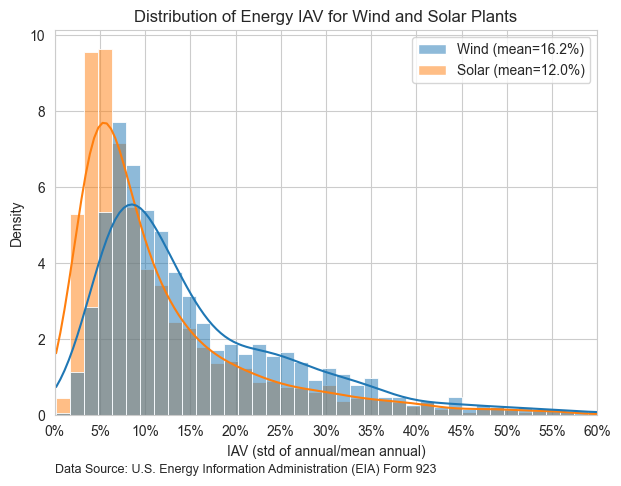

In [30]:
# show a normalized histogram of the data
fig, ax = plt.subplots(figsize=(7, 5))
plot_df = pd.DataFrame({"Wind": wind_iav, "Solar": solar_iav})
means = plot_df.mean()
plot_df.columns = [f"{col} (mean={means[col]:.1%})" for col in plot_df.columns]
sns.histplot(data=plot_df, ax=ax, stat="density", common_norm=False, bins=60, kde=True)
ax.set_xlabel("IAV (std of annual/mean annual)")
# # set xlabel as percentages
ax.set_xlim(0, 0.6)
ax.set_xticks(np.arange(0, 0.61, 0.05))
ax.set_xticklabels(
    [
        "0%",
        "5%",
        "10%",
        "15%",
        "20%",
        "25%",
        "30%",
        "35%",
        "40%",
        "45%",
        "50%",
        "55%",
        "60%",
    ]
)
ax.set_title("Distribution of Energy IAV for Wind and Solar Plants")
ax.text(
    0,
    -0.15,
    "Data Source: U.S. Energy Information Administration (EIA) Form 923",
    transform=ax.transAxes,
    fontsize=9,
    ha="left",
)

In [36]:
def calc_anomaly_from_cod(annual:pd.DataFrame,min_pct:float=0.2) -> pd.DataFrame:
    df = annual.div(annual.mean(axis=0),axis=1)
    df = df.where((df>0.1) & (df<2))
    df = pd.concat({col:df[col].dropna().reset_index(drop=True) for col in df},axis=1)
    df = df.stack().reset_index()
    df.columns = ["year","series_id","iav"]
    df['year']=(df['year']+1).astype(int)
    plant_counts_by_year = df['year'].value_counts()
    valid_years = plant_counts_by_year[plant_counts_by_year>=(plant_counts_by_year.max()*min_pct)].index
    df = df[df['year'].isin(valid_years)]
    return df

def plot_iav_from_cod(df:pd.DataFrame,title:str,min_pct=0.2):
    # show a box plot with x = year and y = iav
    fig,ax = plt.subplots(figsize=(6.5,5))
    # show with 50% transparency
    sns.boxplot(data=df, x="year", y="iav", hue='tech',ax=ax,showfliers=False,boxprops=dict(alpha=.5))
    ax.set_title(title)
    ax.set_xlabel('Project Year from COD')
    ax.set_ylabel('Net Energy (Annual / Mean Annual)')
    # make y axis as percentages every 10%
    ax.set_yticks(np.arange(0, 2.1, 0.1))
    ax.set_yticklabels([f"{int(y*100)}%" for y in np.arange(0, 2.1, 0.1)])
    # show a horizontal line at y=1
    ax.axhline(1, color='k', linestyle='--')
    # show a regression line with the equation y = mx + b
    from scipy.stats import linregress
    for tech in df['tech'].unique():
        tech_df = df[df['tech']==tech]
        x = tech_df['year']
        y = tech_df['iav']
        m, b, r, p, se = linregress(x, y)
        ax.plot(x-1, m*x + b,linewidth=3,label=f'{tech} slope = {m:.1%}/yr')
    ax.legend()
    # add a caption
    ax.text(0, -0.15, 'Data Source: U.S. Energy Information Administration (EIA) Form 923', transform=ax.transAxes, fontsize=9, ha='left')
    ax.text(0, -0.18, f'Project Years with >{min_pct*100:.0f}% of max', transform=ax.transAxes, fontsize=9, ha='left')
    
    return fig,ax

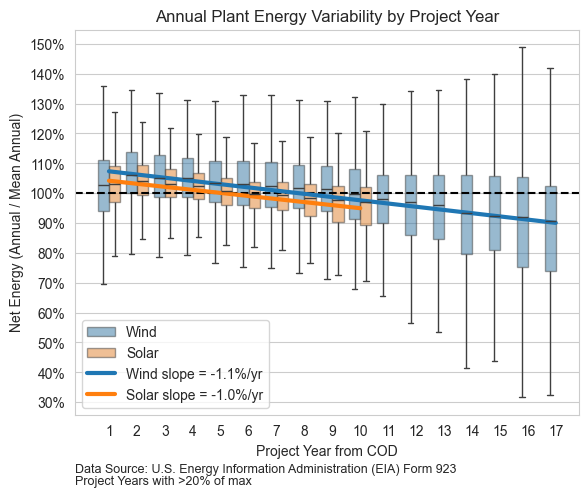

In [37]:
min_pct=0.20
wind_iav_from_cod = calc_anomaly_from_cod(wind_annual,min_pct=min_pct)
solar_iav_from_cod = calc_anomaly_from_cod(solar_annual,min_pct=min_pct)
combined = pd.concat([wind_iav_from_cod.assign(tech='Wind'),solar_iav_from_cod.assign(tech='Solar')])
fig,ax = plot_iav_from_cod(combined,title="Annual Plant Energy Variability by Project Year",min_pct=min_pct)